# Heat Flow Example Problem  

Charlie Dey provided an excellent Introduction to Scientific Computing webinar that is available through the DesignSafe learning center at https://www.designsafe-ci.org/learning-center/training/ and via YouTube at https://youtu.be/GbkCt7u7v0o?si=N4F0i3p-u2vinQlK. As part of Charlie's webinar, he solves a 2-dimensional heat flow problem in an isotropic plate using the finite difference approximation, and he uses nested loops to compute the temperature within the plate. The nested loops provide an intuitive structure to the code that makes it easy for users to understand, but it is inefficient because Python is an interpreted language.

In this notebook, we solve the same heatflow problem using vectorized Numpy and also using Numba and Just-In-Time compiling (JIT). We provide a comparison of the performance of the different codes.

## Heat Flow Problem

The relative performance of different coding approaches is demonstrated using a finite difference solution to the 2D transient heat flow problem for a square domain with a constant initial temperature subject to a temperature change on the top.

## Governing Differential Equation

$\frac{\partial T}{\partial t} = \alpha \left[ \frac{\partial ^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right]$  

T = temperature  
t = time  
x = horizontal dimension  
y = vertical dimension  
$\alpha$ = thermal diffusivity  

## Finite Difference Approximation for a Rectangular Mesh  

The finite difference approximation we use here is explicit, meaning that the state of the model for time step $i$ is used to project the state of the model at time step $i+1$. Explicit methods have the benefit of being easy to code because we don't have to solve a linear system of equations. However, they suffer the detriment that they are numerically unstable if the time step is too large.  

$\frac{\partial T}{\partial t} \approx \frac{T_{ij}^{k+1} - T_{ij}^{k}}{\Delta t}$  

$\frac{\partial ^2 T}{\partial x^2} \approx \alpha \frac{T_{i+1,j}^k -2T_{i,j}^k + T_{i-1,j}^k}{\Delta x^2}$  

$\frac{\partial ^2 T}{\partial y^2} \approx \alpha \frac{T_{1,j+1}^k -2T_{i,j}^k + T_{i,j-1}^k}{\Delta y^2}$   

$\Delta x$ = node spacing in x-direction  
$\Delta y$ = node spacing in y-direction  
$\Delta t$ = time step  
i = index counter for x-direction  
j = index counter for y-direction  
k = index counter for time  

### Resulting Approximation After Making Substitutions  

$\frac{T_{ij}^{k+1} - T_{ij}^{k}}{\Delta t} = \alpha \frac{T_{i+1,j}^k -2T_{i,j}^k + T_{i-1,j}^k}{\Delta x^2} + \alpha \frac{T_{1,j+1}^k -2T_{i,j}^k + T_{i,j-1}^k}{\Delta y^2}$ 

### If $\Delta x = \Delta y$ we obtain the following  

$\frac{T_{ij}^{k+1} - T_{ij}^{k}}{\Delta t} = \alpha \frac{T_{i+1,j}^k + T_{1,j+1}^k -4T_{i,j}^k + T_{i-1,j}^k + T_{i,j-1}^k}{\Delta x^2}$  

### Solving for $T_{ij}^{k+1}$ and re-arranging terms  

$T_{ij}^{k+1} = \gamma\left(T_{i+1,j}^k + T_{1,j+1}^k + T_{i-1,j}^k + T_{i,j-1}^k\right) + \left(1 - 4\gamma\right)T_{ij}^k$ 

where $\gamma = \frac{\alpha \Delta t}{\Delta x^2}$  

Note: the solution will become unstable if $\left(1 - \frac{4\alpha \Delta t}{\Delta x^2} \right) < 0$. We therefore set the time step as shown below  

$\Delta t = \frac{\Delta x^2}{4\alpha}$  

Using the time step above, we find that $\left(1-4\gamma\right)=0$ and therefore the resulting equation is:  

$T_{ij}^{k+1} = \gamma\left(T_{i+1,j}^k + T_{i,j+1}^k + T_{i-1,j}^k + T_{i,j-1}^k\right)$  

In [9]:
# Loop-based solution from Charlie's webinar

def calculate_python_loops(T,gamma):
    Nt = len(T)
    Nx = len(T[0])
    for k in range(0,Nt-1,1):
        for i in range(1,Nx-1,1):
            for j in range(1,Nx-1,1):
                # Implement inner loop
    return T

### Vectorized Numpy solution  

In order to vectorize the calculation, we will use Numpy arrays and we will replace the Python loops with Numpy array slicing notation. By replacing the Python loops, we are shifting the loops from the Python interpreter to the precompiled Numpy code that is much more efficient.  

#### A note on Numpy arrays vs. Python lists  

A Numpy array is a data structure in which all of the elements have the same type, and the array has a fixed size. Numpy arrays are often confused with Python lists because the notation is similar. A Python list is simply a container for any type of data. Vectorized calculations cannot be performed on Python lists because lists do not have a fixed data type.

In [10]:
def calculate_numpy_vectorized(T,gamma):
    '''
    T = three-dimensional Numpy array intialized with boundary conditions and initial conditions
    gamma = finite difference constant, gamma = alpha * dt / dx **2
    alpha = thermal diffusivity
    dt = time step  
    dx = node spacing (same in horizontal and vertical directions)  
    '''
    # Add implementation here
    return T

In [11]:
import numpy as np
import matplotlib.pyplot as plt

L = 50
Nt = 1000
Nx = 50
alpha = 2.0
dx = L/Nx
dt = dx**2/4.0/alpha
gamma = alpha*dt/dx/dx
T_top = 100.0
T_left = 0.0
T_right = 0.0
T_bottom = 0.0
T_initial = 0.0

# Initialize Numpy array T to store temperature values
T = np.full((Nt,Nx,Nx),T_initial,dtype=float)
T[:,:,:1] = T_left
T[:,:,Nx-1] = T_right
T[:,:1,:] = T_bottom
T[:,Nx-1:, :] = T_top

## Using Numba JIT

In [12]:
import numba
import numpy as np
from numba.typed import List


def calculate_numba(T, gamma):
    Nt = len(T)
    Nx = len(T[0])
    for k in range(0, Nt - 1, 1):
        for i in range(1, Nx - 1, 1):
            for j in range(1, Nx - 1, 1):
                T[k + 1, i, j] = gamma * (T[k, i + 1, j] + T[k, i - 1, j] + T[k, i, j + 1] + T[k, i, j - 1])
    return T

In [13]:
import time
start_time = time.time()
T_python_loops = calculate_python_loops(T, gamma)
print(f"Python loops: = {time.time() - start_time:.3f} seconds")
start_time = time.time()
T_numpy_vectorized = calculate_numpy_vectorized(T, gamma)
print(f"Numpy vectorized: = {time.time() - start_time:.3f} seconds")
start_time = time.time()
T_numba = calculate_numba(T, gamma)
print(f"Numba JIT (first run): = {time.time() - start_time:.3f} seconds")
start_time = time.time()
T_numba = calculate_numba(T, gamma)
print(f"Numba JIT (second run): = {time.time() - start_time:.3f} seconds")

Python loops: = 1.098 seconds
Numpy vectorized: = 0.009 seconds
Numba JIT (first run): = 0.071 seconds
Numba JIT (second run): = 0.001 seconds


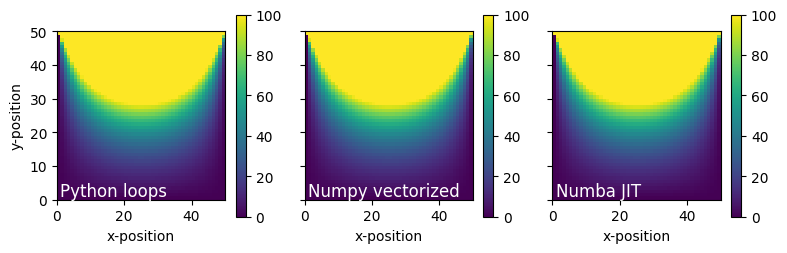

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3,figsize=(8,3),sharey='row')
k = 999
data = {'Python loops':T_python_loops[k], 'Numpy vectorized':T_numpy_vectorized[k], 'Numba JIT':T_numba[k]}
i = 0
for key, value in data.items():
    pcm = ax[i].pcolormesh(value, cmap=plt.cm.viridis, vmin=0, vmax=100)
    ax[i].set_xlabel('x-position')
    ax[i].set_aspect('equal')
    ax[i].annotate(key, xy=(1,1), c='white', fontsize=12)
    fig.colorbar(pcm,ax=ax[i],shrink=0.75)
    i+=1    
ax[0].set_ylabel('y-position')
#fig.colorbar(pcm)
plt.tight_layout()